In [1]:
import sys
sys.path.append('./python')

In [2]:
import needle as ndl
import needle.nn as nn
from needle import array_api, Tensor, NDArray
import numpy as np
from matplotlib import pyplot as plt

In [3]:
device = ndl.cpu()
model = nn.Unet(device=device)
optimizer = ndl.optim.Adam(model.parameters(), lr=1e-3)

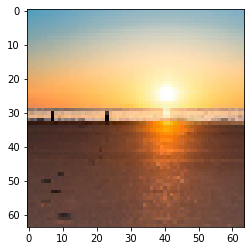

In [4]:
from pathlib import Path
from needle.autograd import Tensor


def plot_landscape(img):
    img = np.transpose(img, (1, 2, 0))
    img = (img + 1) / 2
    plt.imshow(img);


DATA_DIR = Path('./data/landscapes/')
IMAGE_FILES = sorted(str(x) for x in list(DATA_DIR.rglob('*.jpg')))

transforms = [
    ndl.data.RandomFlipHorizontal(),
    ndl.data.Lambda(lambda img: np.transpose(img, (2, 0, 1))),
]

dataset = ndl.data.LandscapesDataset(
    IMAGE_FILES, extra_transforms=transforms, img_size=64
)
plot_landscape(dataset[12])

In [5]:
timesteps = 300
module = nn.Diffusion(model, optimizer, timesteps, loss_type="l2", device=device)

In [6]:
epochs = 1
batch_size = 16
dataloader = ndl.data.DataLoader(dataset, batch_size)
device=ndl.cpu()

In [7]:
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        # Algorithm 1 line 3: sample t uniformally for every example in the batch
        batch = ndl.Tensor(batch, device=device)
        t = Tensor(np.random.randint(0, timesteps, (batch_size,)), device=device)

        loss = module.p_losses(batch, t)

        if step % 100 == 0:
            print("Loss:", loss.cached_data[0])

        loss.backward()
        module.optimizer.step()

(16, 3, 64, 64) <-- x0 shape
(16, 1, 1, 1) <---- extract shape
Array is not compact
H.shape = (16, 64, 64, 64)
time_emb.shape = (16, 64, 64, 64)
Array is not compact
Array is not compact
H.shape = (16, 128, 32, 32)
time_emb.shape = (16, 128, 32, 32)
Array is not compact
Array is not compact
H.shape = (16, 256, 16, 16)
time_emb.shape = (16, 256, 16, 16)
Array is not compact
Array is not compact
H.shape = (16, 512, 8, 8)
time_emb.shape = (16, 512, 8, 8)
Array is not compact
(16, 512, 4, 4) (16, 512, 4, 4)
Array is not compact
H.shape = (16, 256, 4, 4)
time_emb.shape = (16, 256, 4, 4)
Array is not compact
(16, 256, 8, 8) (16, 256, 8, 8)
Array is not compact
H.shape = (16, 128, 8, 8)
time_emb.shape = (16, 128, 8, 8)
Array is not compact
(16, 128, 16, 16) (16, 128, 16, 16)
Array is not compact
H.shape = (16, 64, 16, 16)
time_emb.shape = (16, 64, 16, 16)
Array is not compact
(16, 64, 32, 32) (16, 64, 32, 32)
Array is not compact
H.shape = (16, 32, 32, 32)
time_emb.shape = (16, 32, 32, 32)
Ar

AttributeError: 'Tensor' object has no attribute 'item'